In [14]:
from gensim.models import Word2Vec

model_path = "/home/vlnsha004/CSC2005Z/lpe_soccerevents/models/anon/Seq2vec_60_800_10_1_20_shuffled_sample_skip_hs.model"
model = Word2Vec.load(model_path)

In [15]:
# Get vocab of model

w2v_vocabulary = model.wv.key_to_index
print((w2v_vocabulary))

{'Pass_to': 0, 'Pass_received_by': 1, 'Ground_Pass': 2, 'medium_pass': 3, 'ball_carry_to': 4, 'short_pass': 5, 'High_Pass': 6, '(3,1)': 7, 'long_pass': 8, '(3,5)': 9, '(3,2)': 10, '(3,4)': 11, '(3,3)': 12, '(4,5)': 13, '(4,1)': 14, '(2,2)': 15, '(2,4)': 16, '(4,4)': 17, '(4,2)': 18, 'Low_Pass': 19, '(2,1)': 20, '(2,3)': 21, '(2,5)': 22, '(1,3)': 23, '(4,3)': 24, '(5,5)': 25, '(5,1)': 26, 'ball_receive_failed': 27, '(5,3)': 28, '(5,2)': 29, '(5,4)': 30, '(1,4)': 31, '(1,2)': 32, '(1,1)': 33, '(1,5)': 34, 'Lionel_Andrés_Messi_Cuccittini': 35, 'clearance': 36, 'Cross': 37, 'Tackle': 38, 'Aerial_Lost': 39, 'Sergio_Busquets_i_Burgos': 40, 'Xavier_Hernández_Creus': 41, 'Andrés_Iniesta_Luján': 42, 'Head': 43, 'Interception': 44, 'Gerard_Piqué_Bernabéu': 45, 'Complete_dribble': 46, 'Jordi_Alba_Ramos': 47, 'Daniel_Alves_da_Silva': 48, 'Incomplete_dribble': 49, 'Ivan_Rakitić': 50, 'Right_Foot': 51, 'Duel_Success_In_Play': 52, 'Javier_Alejandro_Mascherano': 53, 'Neymar_da_Silva_Santos_Junior': 54

In [16]:
import pandas as pd

fifa =  pd.read_csv('/home/vlnsha004/CSC2005Z/lpe_soccerevents/data/male_players.csv', delimiter=',', low_memory=False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [ ]:
fifa = fifa.query('fifa_version > 23.0')
fifa = fifa.sort_values(['overall', 'player_positions'], ascending = False)
fifa['long_name'] = fifa['long_name'].str.replace(' ', '_')

fifa = fifa.reset_index(drop=True, inplace=False) # reset the indices
fifa = fifa.rename_axis("index", axis="columns")
trimmed_fifa = fifa[["long_name", "player_positions", "player_tags", "player_traits"]]
top400 = trimmed_fifa[:401]

In [73]:
def compare(baller, sim_player, pd_fifa, trials, type) -> int:
	'''type -> compare positions or traits or tags'''
	'''type: string representing column name '"player_positions", "player_tags", "player_traits"'''

	baller_positions = (pd_fifa.loc[pd_fifa['long_name'] == baller, type]).unique().tolist()
	if len(baller_positions) == 0 or str(baller_positions[0]) == 'nan':
		# print(f'{baller} has no player attributes (tags, traits or positions) in FIFA\n')
		trials = 1
		# print(f'Trials = {trials}\n')
		return [0, trials]
	baller_set = set(baller_positions[0].split(', '))
	# Return 1 if sim_player plays any of the baller's positions, 0 otherwise
	# Find rows where sim_player is a subset of long_name efficiently with vectorization
	subset_mask = pd_fifa['long_name'].str.contains(sim_player[0], case=False, regex=False)  # Case-insensitive
	# Assuming there's only one matching record (use .iloc[0] for the first)
	matching_row = pd_fifa[subset_mask]
	retrieval_w2v_positions = matching_row[type].unique().tolist()
	if len(retrieval_w2v_positions) == 0 or 'nan' in (str(retrieval_w2v_positions)):
		# print(f'{sim_player[0]} has no player attributes (tags, traits or positions) in FIFA\n')
		# print(f'Trials = {trials}\n')
		return [0, trials]
	elif len(retrieval_w2v_positions) > 1:
		# print(f'{sim_player[0]}: {retrieval_w2v_positions}')
		retrieval_set = set(retrieval_w2v_positions[1].split(', '))
		# print(f'{baller}: {baller_positions}')    
		# print(f'similar player set: {retrieval_set}')
		# print(f'baller set: {baller_set}')
		# print(f'intersection: {retrieval_set & baller_set}')
		if (retrieval_set & baller_set):
			# print('SIMILAR PLAYER FOUND\n')
			trials += 1
			return [1, trials]
		else:
			# print('No match\n')
			trials += 1
			return [0, trials]
	else:
		# print(f'{sim_player[0]}: {retrieval_w2v_positions}')
		retrieval_set = set(retrieval_w2v_positions[0].split(', '))
		# print(f'{baller}: {baller_positions}')    
		# print(f'similar player set: {retrieval_set}')
		# print(f'baller set: {baller_set}')
		# print(f'intersection: {retrieval_set & baller_set}')
		if (retrieval_set & baller_set):
			# print('SIMILAR PLAYER FOUND\n')
			trials += 1
			return [1, trials]
		else:
			# print('No match\n')
			trials += 1
			return [0, trials]
	

In [74]:
import random
import numpy as np

def get_pak_vector(top400, base=False, type="player_positions", model=model):

	similar_players = {}

	for player in top400['long_name']:
		# Create dictionary with {"Eriksen": ["Davies", "Mignolet", "Ronaldo"], "Johnathan": ["Bakambu", "Cedric"]}
		try: 
			if base:
				all_players = model.wv.index_to_key # Set of all players in the model
				random_players = random.sample(all_players, 600) # Sampe may contain actions/players not in EAFC
				similar_players[player] = [(other_player, model.wv.similarity(player, other_player)) for other_player in random_players if other_player != player and other_player in top400['long_name'].values]
			else:
				similar_players[player] = model.wv.most_similar(player, topn=70)
		except KeyError:
			continue
	print(similar_players)
	print(len(similar_players.keys()))
	# Create an array to store the precision at 20 for each player in selected_columns, retrieving similar players by the model
	pak_store = []
	for baller, similar in similar_players.items(): # Loop through the key-value pairs
		counter = 0
		trials = 0
		# print(f'{baller}: {similar}')
		baller_positions = (trimmed_fifa.loc[trimmed_fifa['long_name'] == baller, type]).unique().tolist()
		if len(baller_positions) == 0 or 'nan' in (str(baller_positions)):
			# print(f'{baller} has no player attributes (tags, traits or positions) in FIFA\n')
			continue
		# Begin trials
		for sim_player in similar: # For each player in similar set:	
			[match, new_trial] = compare(baller, sim_player, trimmed_fifa, trials, type)
			counter += match
			trials = new_trial
			if trials == 10:
				prop = counter/trials
				break
		# If we do not have 10 trials, do not include in the precision at 10 calculation
		# Have gone through all retrievals and found no viable comparisons
		if trials < 10:
			# print(f'Less than 10 data points for similar players to {baller} in FIFA\n')
			continue

		# print(f'{baller}: Correct:{counter}, Trials:{trials}, Percent: {prop}\n')
		pak_store.append(prop) # Store the precision at 20 for each player
		if len(pak_store) == 45:
			break
	ave_precision_k = round(np.mean(pak_store) * 100, 2)
	print(f'Evaluation Type: {type}'+ '\n'+ f'Length: {len(pak_store)}'+ '\n'+ f'Vector: {pak_store}'+ '\n'+ f'Precision at 10: {ave_precision_k}')
	return ave_precision_k

In [75]:
pak = get_pak_vector(top400, base=False, type="player_positions", model = model)
print(f'Mean Average Precision at 10: {pak}')

{'Kylian_Mbappé_Lottin': [('David_Villa_Sánchez', 0.8373878002166748), ('Neymar_da_Silva_Santos_Junior', 0.8209549784660339), ('Cristiano_Ronaldo_dos_Santos_Aveiro', 0.8176447749137878), ('Bojan_Krkíc_Pérez', 0.8166839480400085), ('Luis_Alberto_Suárez_Díaz', 0.8159142136573792), ('Thierry_Henry', 0.8066018223762512), ('Lorenzo_Insigne', 0.8048007488250732), ('Samuel_Etoo_Fils', 0.7937240600585938), ('Zlatan_Ibrahimović', 0.7881607413291931), ('Philippe_Coutinho_Correia', 0.7755608558654785), ('Ronaldo_de_Assis_Moreira', 0.7739994525909424), ('Karim_Benzema', 0.7720322012901306), ('Anssumane_Fati', 0.7688050866127014), ('Marco_Reus', 0.767595648765564), ('Gustavo_Nery_De_Sá_Da_Silva', 0.7670199275016785), ('Gonzalo_Gerardo_Higuaín', 0.766948401927948), ('Sergio_Leonel_Agüero_del_Castillo', 0.7665615677833557), ('Raheem_Sterling', 0.7662031650543213), ('Lionel_Andrés_Messi_Cuccittini', 0.7648162841796875), ('Andrés_Iniesta_Luján', 0.7629187107086182), ('Rubén_Castro_Martín', 0.7628840804

In [76]:
import os
from gensim.models import Word2Vec

directory = "/home/vlnsha004/CSC2005Z/lpe_soccerevents/models/anon/"
types = ["player_positions", "player_tags", "player_traits"]
models = {}

for filename in os.listdir(directory):
    if filename.endswith(".model"):
        model_path = os.path.join(directory, filename)
        model_name = filename[:-6]  # remove ".model" from the filename
        models[model_name] = Word2Vec.load(model_path)
        

{'M1': 'Seq2vec_30_500_12_1_20_shuffled', 'M2': 'Seq2vec_60_800_10_1_20_shuffled_sample_skip_hs', 'M3': 'Seq2vec_30_500_6_1_20_shuffled', 'M4': 'Seq2vec_30_500_3_1_20_shuffled', 'M5': 'Seq2vec_50_300_5_1_5_shuffled', 'M6': 'Seq2vec_30_500_6_1_5_shuffled', 'M7': 'Seq2vec_30_500_3_1_5_shuffled'}
Random retrieval
{'Kylian_Mbappé_Lottin': [('Giovanni_Di_Lorenzo', 0.3060584), ('Bernardo_Mota_Veiga_de_Carvalho_e_Silva', 0.5887612)], 'Kevin_De_Bruyne': [('Keylor_Navas_Gamboa', 0.3036585), ('Pedro_González_López', 0.5876552), ('Riyad_Mahrez', 0.61847657), ('Kieran_Trippier', 0.5606275)], 'Robert_Lewandowski': [('Luka_Modrić', 0.51605004), ('João_Pedro_Cavaco_Cancelo', 0.4568116), ('Iago_Aspas_Juncal', 0.73288375), ('Keylor_Navas_Gamboa', 0.24187618), ('Bernardo_Mota_Veiga_de_Carvalho_e_Silva', 0.5872701), ('Harry_Kane', 0.7594733), ('Karim_Benzema', 0.75807106)], 'Harry_Kane': [('Rodrygo_Silva_de_Goes', 0.55495125), ('Vinícius_José_Paixão_de_Oliveira_Júnior', 0.55830944), ('Giovanni_Di_Lorenzo

KeyboardInterrupt: 

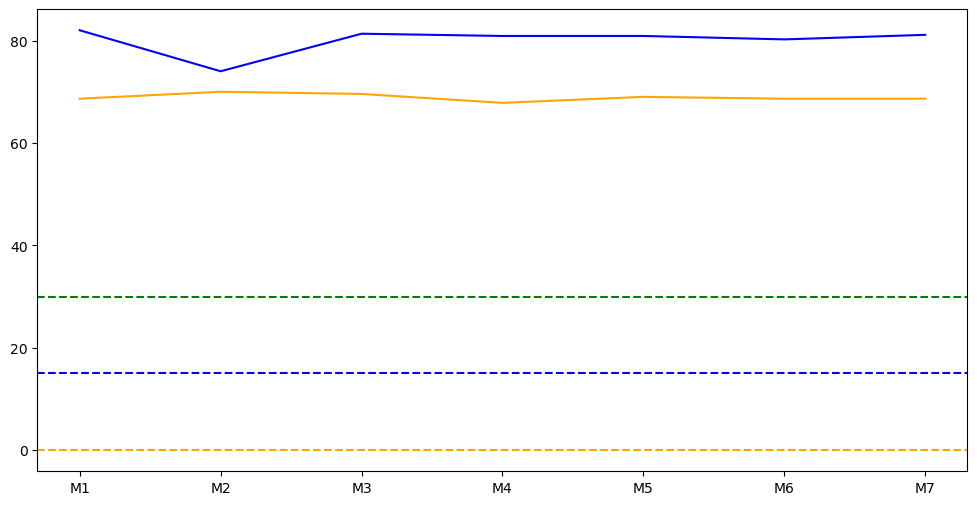

In [77]:
import matplotlib.pyplot as plt
from multiprocessing import Pool

def get_pak_vector_wrapper(args):
    return get_pak_vector(*args)

def plot_pak(models, types):
    fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size of the plot
    colors = ['blue', 'orange', 'green']  # Add more colors if there are more types
    model_names = [f'M{i+1}' for i in range(len(models))]  # Rename the models
    model_info = {f'M{i+1}': name for i, name in enumerate(models.keys())}  # Keep a list of model name: hyperparameters
    print(model_info)
    with Pool() as p:
        for color, type in zip(colors, types):
            print('Random retrieval')
            baseline_pak = get_pak_vector(top400, base=True, type=type)
            ax.axhline(y=baseline_pak, linestyle='--', color=color, label=f'{type} Random')
            tasks = [(top400, False, type, model) for model in models.values()]
            pak = p.map(get_pak_vector_wrapper, tasks)
            ax.plot(model_names, pak, color=color, label=type)
    ax.set_xlabel('Model')
    ax.set_ylabel('Precision @ 10')
    ax.set_title('Precision @ 10 for different models')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_pak(models, types)

In [55]:
# Evaluation and retrievals:

word = 'Lionel_Andrés_Messi_Cuccittini'
try:
	print(model.wv.most_similar(word))
    #Obtain the name of the players with the highest similarity score
	build = ''
	for player in model.wv.most_similar(word, topn=45):
		build += player[0].title().replace('_', ' ') + r'\\' + '\n' + '\hline' + '\n'

	print(build) 

except KeyError:
    print(f"The word {word} does not appear in current model") 



[('Samuel_Etoo_Fils', 0.8154041171073914), ('Ousmane_Dembélé', 0.7844875454902649), ('Sergio_Leonel_Agüero_del_Castillo', 0.7814104557037354), ('Paulo_Bruno_Exequiel_Dybala', 0.775397539138794), ('Zlatan_Ibrahimović', 0.7750627994537354), ('Gonzalo_Gerardo_Higuaín', 0.7745987772941589), ('Édson_Arantes_do_Nascimento', 0.7723499536514282), ('Alexis_Alejandro_Sánchez_Sánchez', 0.7675507068634033), ('Kylian_Mbappé_Lottin', 0.7648162841796875), ('Luis_Alberto_Suárez_Díaz', 0.7616477012634277)]
Samuel Etoo Fils\\
\hline
Ousmane Dembélé\\
\hline
Sergio Leonel Agüero Del Castillo\\
\hline
Paulo Bruno Exequiel Dybala\\
\hline
Zlatan Ibrahimović\\
\hline
Gonzalo Gerardo Higuaín\\
\hline
Édson Arantes Do Nascimento\\
\hline
Alexis Alejandro Sánchez Sánchez\\
\hline
Kylian Mbappé Lottin\\
\hline
Luis Alberto Suárez Díaz\\
\hline
Ronaldo De Assis Moreira\\
\hline
Xavier Hernández Creus\\
\hline
Francesc Fàbregas I Soler\\
\hline
Pedro Eliezer Rodríguez Ledesma\\
\hline
Josip Iličić\\
\hline
Bojan 

In [ ]:
pairs = [
    ('Xavier_Hernández_Creus', word), 
    ('long_pass', word),
    ('High_Pass', word), 
    ('short_pass', word), 
    ('Ronaldo_de_Assis_Moreira', word), 
    ('Shot_Goal', word),
]
for w1, w2 in pairs:
    print(f'{w1}\t{w2}\t{model.wv.similarity(w1, w2)}')

Xavier_Hernández_Creus	Andrea_Pirlo	0.8155089616775513
long_pass	Andrea_Pirlo	0.0917138159275055
High_Pass	Andrea_Pirlo	-0.010526683181524277
short_pass	Andrea_Pirlo	0.2725675404071808
Ronaldo_de_Assis_Moreira	Andrea_Pirlo	0.7450524568557739
Shot_Goal	Andrea_Pirlo	-0.4886319637298584
